In [3]:
import numpy as np
import pandas as pd
from bs4 import BeautifulSoup
import torchvision
from torchvision import transforms, datasets, models
import torch
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from PIL import Image
import matplotlib.pyplot as plt
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor
import matplotlib.patches as patches
import os

In [4]:

def generate_box(obj):
    
    xmin = int(obj.find('xmin').text)
    ymin = int(obj.find('ymin').text)
    xmax = int(obj.find('xmax').text)
    ymax = int(obj.find('ymax').text)
    
    return [xmin, ymin, xmax, ymax]

def generate_label(obj):
    if obj.find('name').text == "with_mask":
        return 2
    elif obj.find('name').text == "mask_weared_incorrect":
        return 3
    return 1

def generate_target(image_id, file): 
    with open(file) as f:
        data = f.read()
        soup = BeautifulSoup(data, 'xml')
        objects = soup.find_all('object')
        num_objs = len(objects)
        boxes = []
        labels = []
        for i in objects:
            boxes.append(generate_box(i))
            labels.append(generate_label(i))
        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        labels = torch.as_tensor(labels, dtype=torch.int64)
        img_id = torch.tensor([image_id])
        target = {}
        target["boxes"] = boxes
        target["labels"] = labels
        target["image_id"] = img_id
        
        return target


In [5]:
from google.colab import drive
drive.mount('/content/gdrive/')

Drive already mounted at /content/gdrive/; to attempt to forcibly remount, call drive.mount("/content/gdrive/", force_remount=True).


In [6]:
imgs = list(sorted(os.listdir("/content/gdrive/MyDrive/images")))


In [7]:
labels = list(sorted(os.listdir("/content/gdrive/MyDrive/annotations")))

In [8]:
class MaskDataset(object):
    def __init__(self, transforms):
        self.transforms = transforms
        self.imgs = list(sorted(os.listdir("/content/gdrive/MyDrive/images")))
        self.labels = list(sorted(os.listdir("/content/gdrive/MyDrive/annotations")))

    def __getitem__(self, idx):
        file_image = 'maksssksksss'+ str(idx) + '.png'
        file_label = 'maksssksksss'+ str(idx) + '.xml'
        img_path = os.path.join("/content/gdrive/MyDrive/images/", file_image)
        label_path = os.path.join("/content/gdrive/MyDrive/annotations/", file_label)
        img = Image.open(img_path).convert("RGB")
        target = generate_target(idx, label_path)
        
        if self.transforms is not None:
            img = self.transforms(img)

        return img, target

    def __len__(self):
        return len(self.imgs)

In [9]:
data_transform = transforms.Compose([
        transforms.ToTensor(), 
    ])

In [10]:
def collate_fn(batch):
    return tuple(zip(*batch))

dataset = MaskDataset(data_transform)
data_loader = torch.utils.data.DataLoader(
 dataset, batch_size=4, collate_fn=collate_fn)

In [11]:
torch.cuda.is_available()

True

# Model

In [12]:
def model_detection(num_classes):
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

    return model

In [13]:
model = model_detection(4)

In [14]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
for imgs, annotations in data_loader:
    imgs = list(img.to(device) for img in imgs)
    annotations = [{q: w.to(device) for q, w in n.items()} for n in annotations]
    print(annotations)
    break

[{'boxes': tensor([[ 79., 105., 109., 142.],
        [185., 100., 226., 144.],
        [325.,  90., 360., 141.]], device='cuda:0'), 'labels': tensor([1, 2, 1], device='cuda:0'), 'image_id': tensor([0], device='cuda:0')}, {'boxes': tensor([[321.,  34., 354.,  69.],
        [224.,  38., 261.,  73.],
        [299.,  58., 315.,  81.],
        [143.,  74., 174., 115.],
        [ 74.,  69.,  95.,  99.],
        [191.,  67., 221.,  93.],
        [ 21.,  73.,  44.,  93.],
        [369.,  70., 398.,  99.],
        [ 83.,  56., 111.,  89.]], device='cuda:0'), 'labels': tensor([2, 2, 2, 2, 2, 2, 2, 2, 1], device='cuda:0'), 'image_id': tensor([1], device='cuda:0')}, {'boxes': tensor([[ 68.,  42., 105.,  69.],
        [154.,  47., 178.,  74.],
        [238.,  34., 262.,  69.],
        [333.,  31., 366.,  65.]], device='cuda:0'), 'labels': tensor([2, 2, 2, 3], device='cuda:0'), 'image_id': tensor([2], device='cuda:0')}, {'boxes': tensor([[ 52.,  53.,  73.,  76.],
        [ 72.,  53.,  92.,  75.],
  

# Train Model

In [15]:

num_epochs = 50
model.to(device)

parameter = [p for p in model.parameters() if p.requires_grad]
opt = torch.optim.SGD(parameter, lr=0.005, momentum=0.9, weight_decay=0.0005)

for epoch in range(num_epochs):
    model.train()
    i = 0    
    epoch_loss = 0
    for imgs, annotations in data_loader:
        i += 1
        imgs = list(img.to(device) for img in imgs)
        annotations = [{q: w.to(device) for q, w in n.items()} for n in annotations]
        loss_dt = model([imgs[0]], [annotations[0]])
        loss = sum(los for los in loss_dt.values())        

        opt.zero_grad()
        loss.backward()
        opt.step()
        epoch_loss += loss
    print(f'epoch: {epoch} losse: {epoch_loss/i}')


epoch: 0 losse: 0.5097000598907471
epoch: 1 losse: 0.3576691746711731
epoch: 2 losse: 0.2787444293498993
epoch: 3 losse: 0.24332107603549957
epoch: 4 losse: 0.2190636396408081
epoch: 5 losse: 0.2154025137424469
epoch: 6 losse: 0.20238623023033142
epoch: 7 losse: 0.1865391582250595
epoch: 8 losse: 0.16489700973033905
epoch: 9 losse: 0.17466036975383759
epoch: 10 losse: 0.1644681841135025
epoch: 11 losse: 0.1445564329624176
epoch: 12 losse: 0.12882816791534424
epoch: 13 losse: 0.1311979442834854
epoch: 14 losse: 0.1446552574634552
epoch: 15 losse: 0.1361331045627594
epoch: 16 losse: 0.11258022487163544
epoch: 17 losse: 0.12022817879915237
epoch: 18 losse: 0.11982396245002747
epoch: 19 losse: 0.12350422143936157
epoch: 20 losse: 0.13117507100105286
epoch: 21 losse: 0.10308700054883957
epoch: 22 losse: 0.10795489698648453
epoch: 23 losse: 0.10492520779371262
epoch: 24 losse: 0.12096137553453445
epoch: 25 losse: 0.1101417988538742
epoch: 26 losse: 0.1060771718621254
epoch: 27 losse: 0.08930

In [16]:
i=0
for imgs, annotations in data_loader:
        i+=1
        imgs = list(img.to(device) for img in imgs)
        annotations = [{q: w.to(device) for q, w in n.items()} for n in annotations]
        if i == 4:
          break

In [17]:
model.eval()
predict = model(imgs)
predict

[{'boxes': tensor([[119.8035,  55.1882, 132.2791,  68.5883],
          [354.0602,  54.0129, 365.2145,  68.5167],
          [153.4279,  60.8768, 171.0295,  81.8458],
          [334.8446,  69.8883, 353.5371,  87.5577],
          [ 94.6889,  59.1753, 101.9745,  69.4800],
          [298.4551,  60.8263, 312.9473,  84.3616],
          [273.1242,  57.9727, 290.7552,  75.7187],
          [ 36.4740,  69.7581,  46.6852,  82.4982],
          [ 38.0144,  81.8839,  45.1399,  98.9999],
          [163.0236,  75.5641, 186.5823,  96.4475],
          [119.1468,  70.2670, 138.4040,  89.2078],
          [231.7872,  60.8140, 249.5644,  78.9899],
          [ 72.4782,  70.8799,  91.2398,  88.8330]], device='cuda:0',
         grad_fn=<StackBackward>),
  'labels': tensor([2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2], device='cuda:0'),
  'scores': tensor([0.9955, 0.9955, 0.9953, 0.9945, 0.9944, 0.9943, 0.9939, 0.9922, 0.9921,
          0.9911, 0.9897, 0.9895, 0.9891], device='cuda:0',
         grad_fn=<IndexBackward>

# Function to plot image

In [18]:
def plot_image(img_tensor, min_score, annotation):
  fig,ax = plt.subplots(1, figsize=(8, 8))
  img = img_tensor.cpu().data

  ax.imshow(img.permute(1, 2, 0))
  dict_class = {1: 'no_mask', 2: 'mask', 3: 'inc_mask'}
  dict_color = {1: 'r', 2: 'g', 3: 'b'}
  spisok = [1, 2, 3]
  k = 0
  for box in annotation["boxes"]:
    xmin, ymin, xmax, ymax = box
    clas = 'None'
    for i in range(3):
      if int(annotation["labels"][k]) == spisok[i]:
        try:
          if annotation["scores"][k] > min_score:
            clas = dict_class[i+1] + ':' + str(round(float(annotation["scores"][k]),2))
            rect = patches.Rectangle((xmin,ymin),(xmax-xmin),(ymax-ymin),linewidth=1,edgecolor=dict_color[i+1],facecolor='none')
        except:
          clas = dict_class[i+1]
          rect = patches.Rectangle((xmin,ymin),(xmax-xmin),(ymax-ymin),linewidth=1,edgecolor=dict_color[i+1],facecolor='none')

    if clas != 'None':
      plt.text(xmax, ymax, f'{clas}', size=(xmax-xmin)/4, rotation=0.,
      ha="right", va="top",
      bbox=dict(boxstyle="square",
                ec=(1., 0.5, 0.5),
                fc=(1., 0.8, 0.8),
               )
      )
    ax.add_patch(rect)
    k += 1 

Prediction
Target


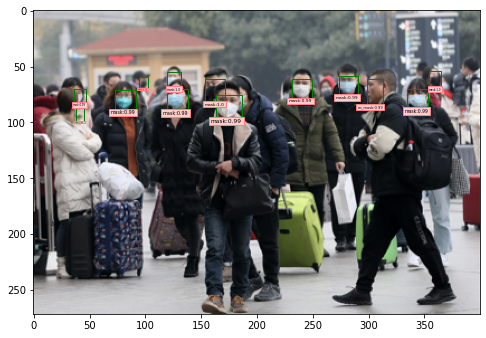

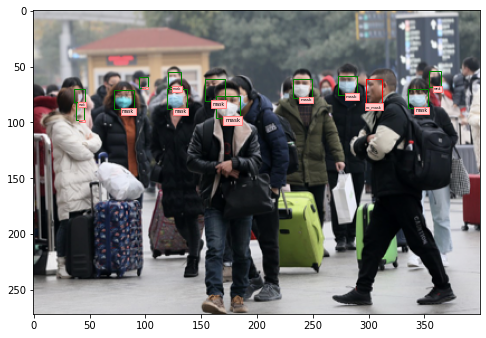

In [26]:
print("Prediction")
plot_image(imgs[0], 0.6, predict[0])
print("Target")
plot_image(imgs[0], 0.6, annotations[0])


Prediction
Target


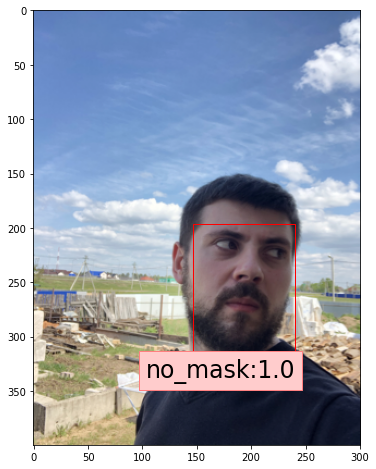

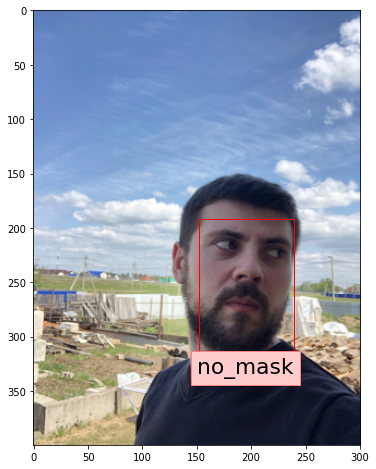

In [27]:
print("Prediction")
plot_image(imgs[2], 0.6, predict[2])
print("Target")
plot_image(imgs[2], 0.6, annotations[2])